In [7]:
import os
import sys
from readrec import *
import matplotlib
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
import re
import glob

from scipy.constants import speed_of_light

c = speed_of_light

sps = 10e6 # 10 Msps

%matplotlib inline
%config InlineBackend.close_figures=True

In [11]:
## Bourka hnědouhelné doly 
#files = ['/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80',
#         '/storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80',
#         '/storage/experiments/2022/0909_bourka_CAR1/parallella-VLF/rec_220909-161250.81']

#files = ['/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF/rec_220826-163022.70',
#         '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/parallella-VLF/rec_220826-163022.43',
#         '/storage/experiments/2022/0826_bourka_staryvestec_CAR1/parallella/rec_220826-163022.62']

#files = ['/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF/rec_220826-163022.70']

files = ['/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF/rec_220826-160903.93']


multistation_plotrec(files)

NameError: name 'multistation_plotrec' is not defined

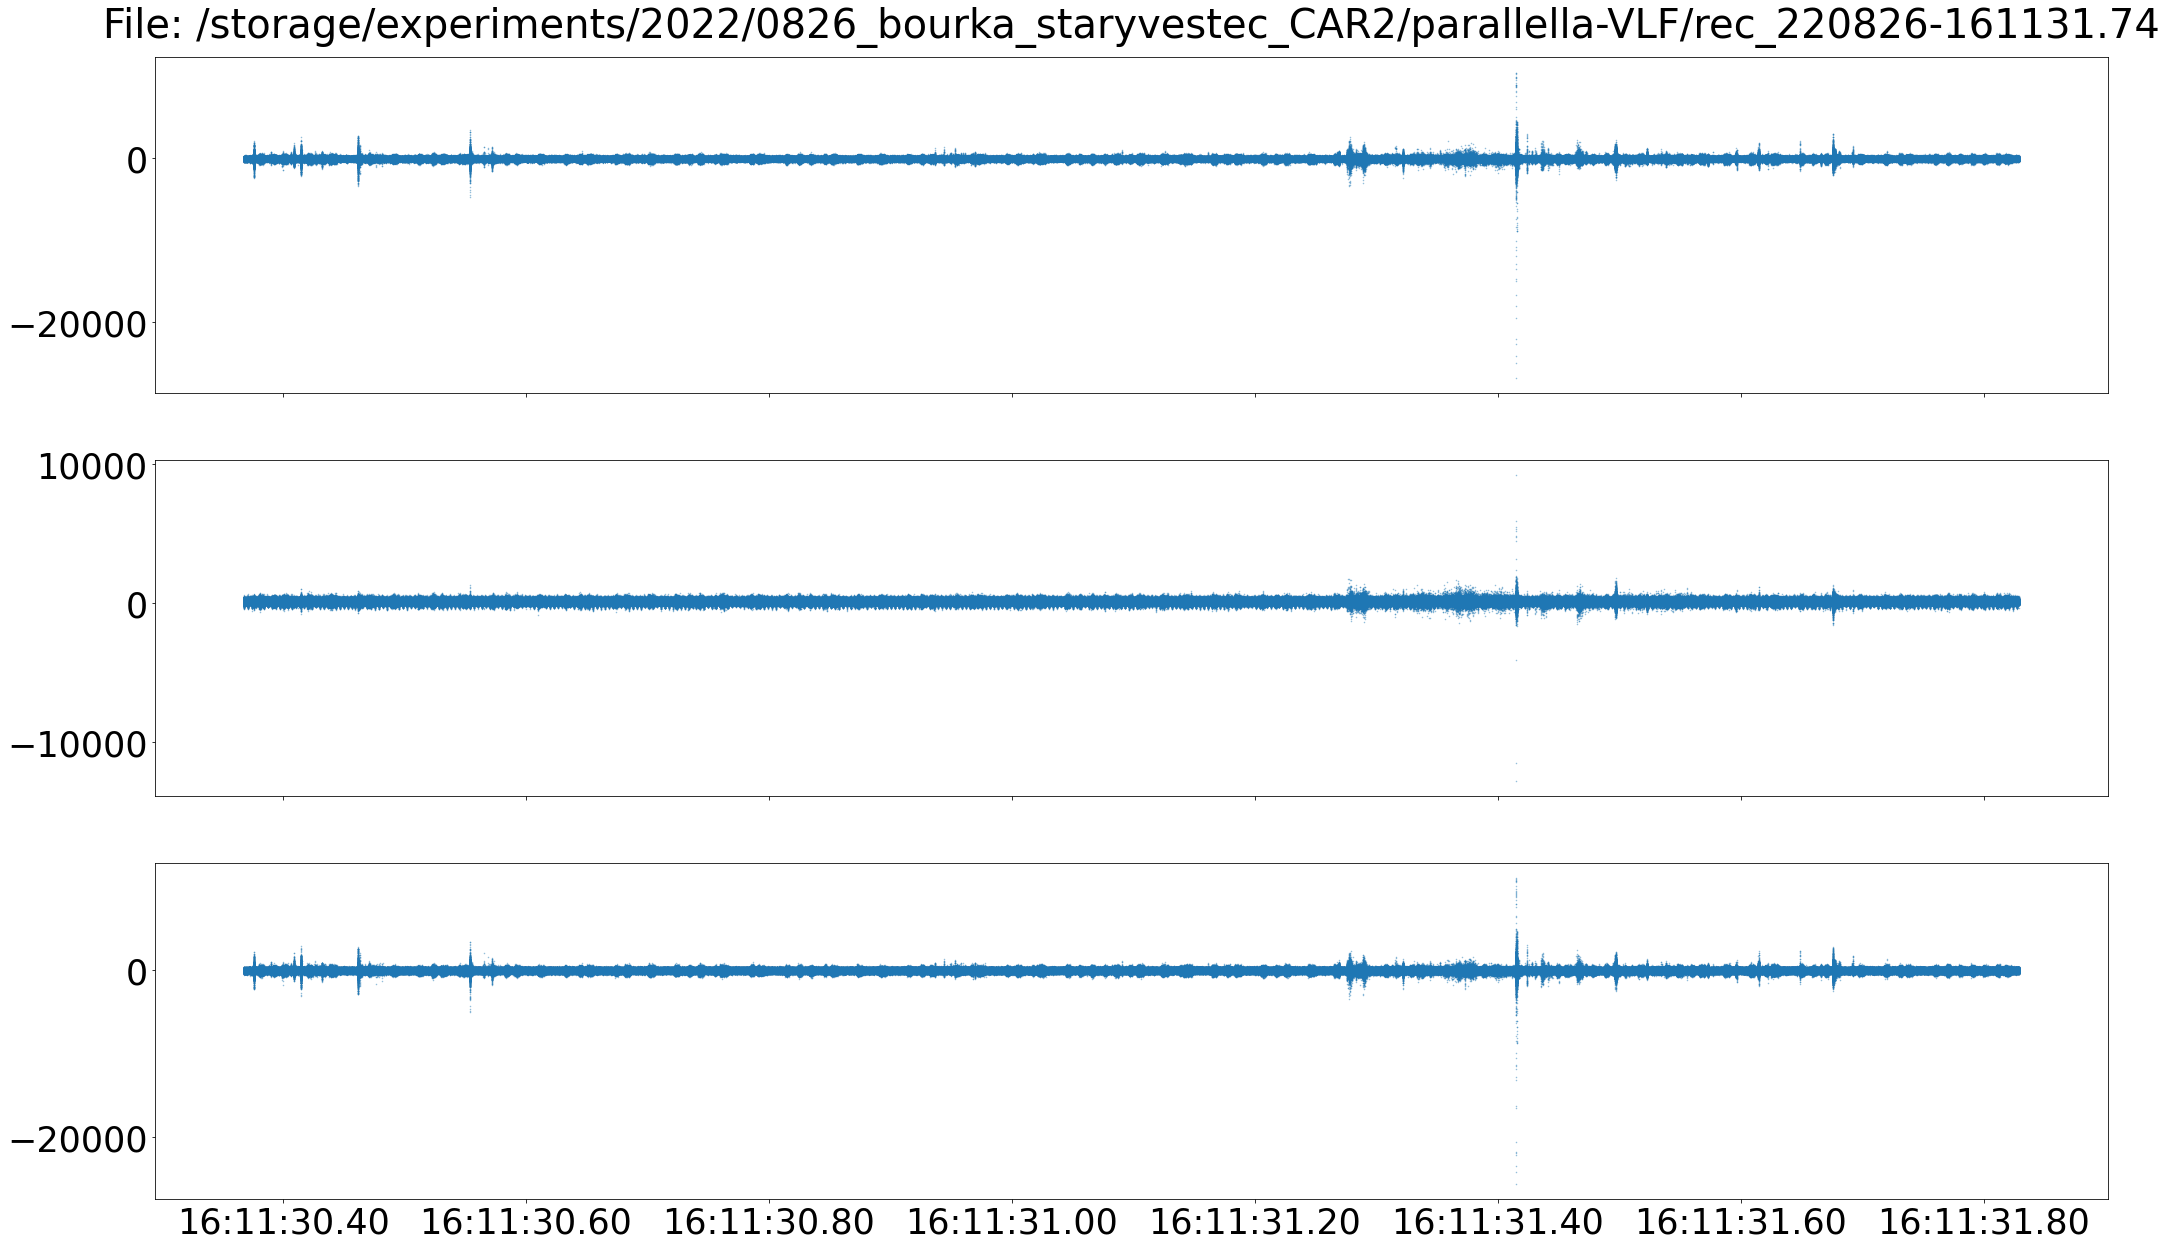

In [13]:

filepath = '/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF/rec_220826-161131.74'

channels = [0, 1, 3]
nrows = len(channels) * 1
fig, axs = plt.subplots(figsize=(35, 7 * nrows), nrows=nrows, sharex=True)

mintime = None
data = []

# Load and process data
try:
    with open(filepath, 'rb') as file:
        fn = os.path.basename(filepath)
        h, samples, synclog = loadrec(file)
        t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)

        time = s2t(0)
        mintime = time if mintime is None else min(mintime, time)

        # Add data to the list for later processing
        data.append((filepath, h, samples, synclog, t2s, s2t, ticker, formatter))
except Exception as e:
    print(f"Exception: {e}")

# Render data
ax_idx = 0
for i, (filepath, h, samples, synclog, t2s, s2t, ticker, formatter) in enumerate(data):
    offset = -int(t2s(mintime))

    # Use full path for the file label only once above the first channel
    axs[ax_idx].set_title(f"File: {filepath}", fontsize=40, pad=20)

    a = (h['preTrigger'] - h['preTrigger']) * h['descSpan'] // 16
    b = (h['preTrigger'] + h['postTrigger']) * h['descSpan'] // 16
    for ch in channels:
        signal_samples = samples[a:b, ch]

        axs[ax_idx].xaxis.set_major_locator(ticker)
        axs[ax_idx].xaxis.set_major_formatter(formatter)
        axs[ax_idx].plot(range(a + offset, b + offset), signal_samples, linestyle="", marker=".", alpha=0.5, markersize=1)

        axs[ax_idx].tick_params(axis='x', which='major', labelsize=35)
        axs[ax_idx].tick_params(axis='y', which='major', labelsize=35)

        ax_idx += 1


plt.show()

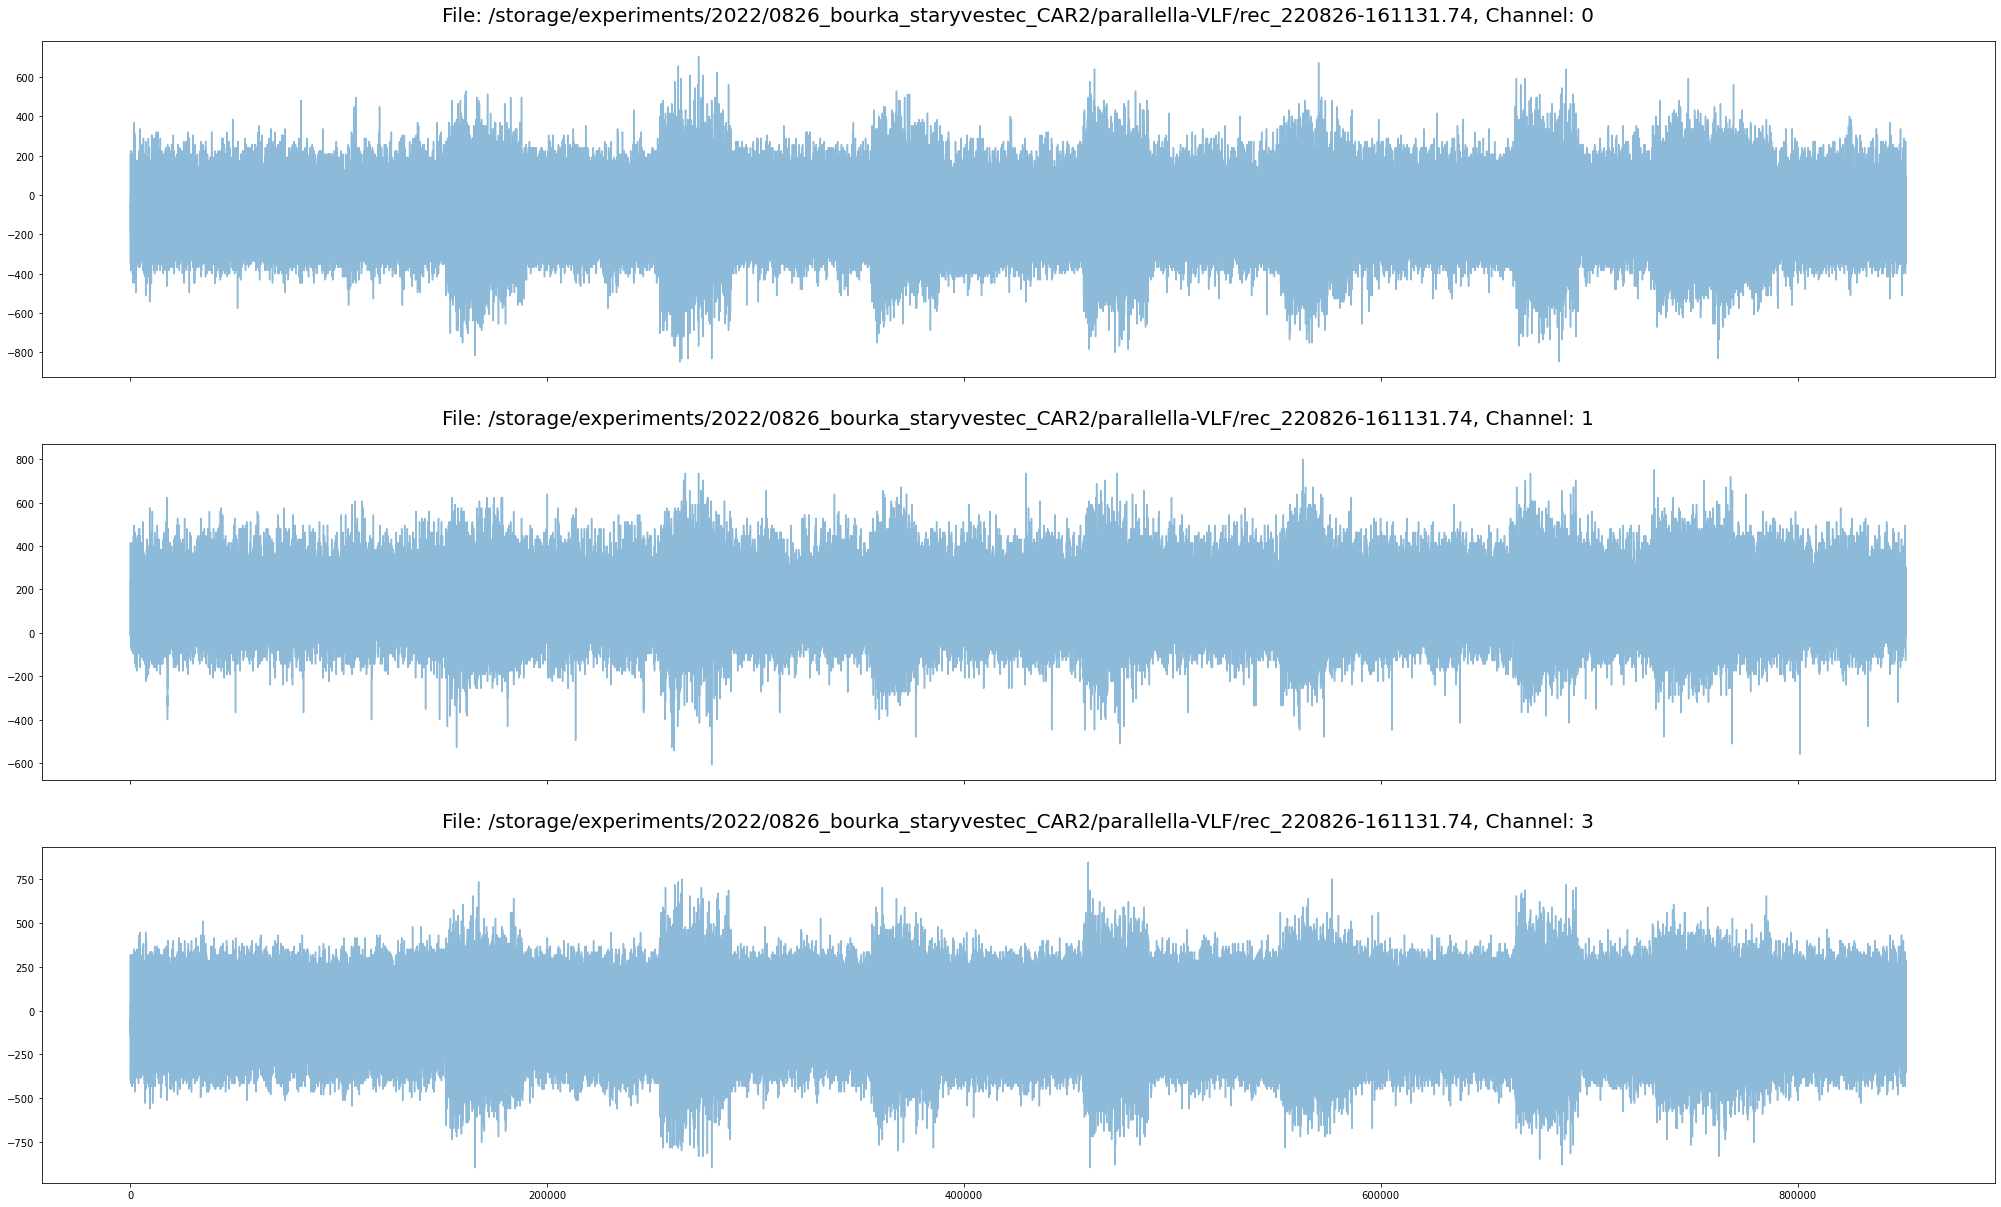

In [12]:
import matplotlib.pyplot as plt
import os

# Předpokládáme, že 'loadrec' a 'assign_time_axis' jsou definovány v externím modulu
from readrec import loadrec, assign_time_axis

filepath = '/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF/rec_220826-161131.74'

channels = [0, 1, 3]
nrows = len(channels)
fig, axs = plt.subplots(figsize=(35, 7 * nrows), nrows=nrows, sharex=True)

data = []

# Nahrání a zpracování dat
with open(filepath, 'rb') as file:
    fn = os.path.basename(filepath)
    h, samples, synclog = loadrec(file)
    t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)

    time = s2t(0)

    # Přidání dat do seznamu pro pozdější zpracování
    data.append((filepath, h, samples, synclog, t2s, s2t, ticker, formatter))

# Vykreslení dat
for i, (filepath, h, samples, synclog, t2s, s2t, ticker, formatter) in enumerate(data):
    a = h['preTrigger'] * h['descSpan'] // 16
    b = (h['preTrigger'] + h['postTrigger']) * h['descSpan'] // 16
    time_a = s2t(a)
    time_b = s2t(b - 1)

    for ax, ch in zip(axs, channels):
        signal_samples = samples[a:b, ch]

        # Nastavení rozsahu a značek na ose x
        #ax.set_xlim(time_a, time_b)

        ax.set_title(f"File: {filepath}, Channel: {ch}", fontsize=20, pad=20)
        #ax.plot(range(a, b), signal_samples, linestyle="", marker=".", alpha=0.5, markersize=1)
        ax.plot(signal_samples,  alpha=0.5, markersize=1)

plt.show()


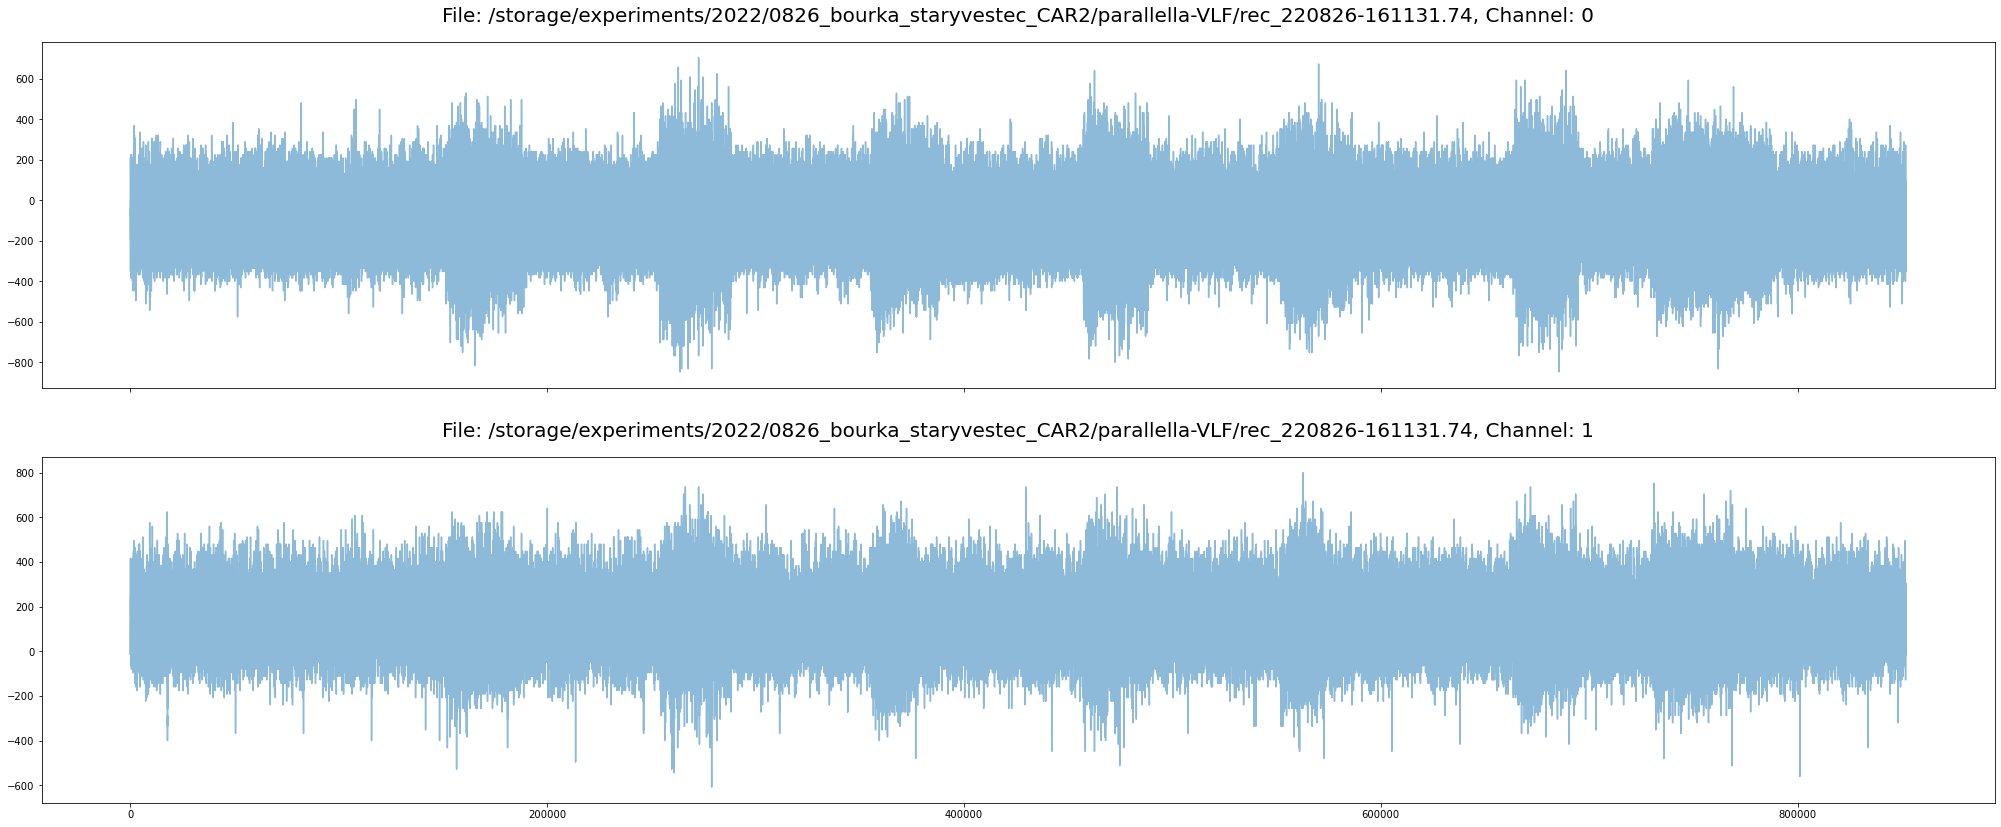

In [15]:
import matplotlib.pyplot as plt
import os

# Předpokládáme, že 'loadrec' a 'assign_time_axis' jsou definovány v externím modulu
from readrec import loadrec, assign_time_axis

filepath = '/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF/rec_220826-161131.74'

channels = [0,1]
nrows = len(channels)
fig, axs = plt.subplots(figsize=(35, 7 * nrows), nrows=nrows, sharex=True)

data = []

# Nahrání a zpracování dat
with open(filepath, 'rb') as file:
    fn = os.path.basename(filepath)
    h, samples, synclog = loadrec(file)
    t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)

    time = s2t(0)

    # Přidání dat do seznamu pro pozdější zpracování
    data.append((filepath, h, samples, synclog, t2s, s2t, ticker, formatter))

# Vykreslení dat
for i, (filepath, h, samples, synclog, t2s, s2t, ticker, formatter) in enumerate(data):
    a = h['preTrigger'] * h['descSpan'] // 16
    b = (h['preTrigger'] + h['postTrigger']) * h['descSpan'] // 16
    time_a = s2t(a)
    time_b = s2t(b - 1)

    for ax, ch in zip(axs, channels):
        signal_samples = samples[a:b, ch]

        # Nastavení rozsahu a značek na ose x
        #ax.set_xlim(time_a, time_b)

        ax.set_title(f"File: {filepath}, Channel: {ch}", fontsize=20, pad=20)
        #ax.plot(range(a, b), signal_samples, linestyle="", marker=".", alpha=0.5, markersize=1)
        ax.plot(signal_samples,  alpha=0.5, markersize=1)

plt.show()


In [ ]:
import datetime
base = datetime.datetime.today()
plt.plot([base - datetime.timedelta(microseconds=x) for x in range(len(samples))],samples[:,0])

In [124]:
# Load of lightning data

blitz = pd.read_csv('/storage/blitzortung/2021-2023/region-1/2022-08-26.log', sep=',', low_memory=False, on_bad_lines='skip')

lat=50.1528464
lon=14.8556861

start=pd.Timestamp('2022-08-26 16:08:00') 
end=pd.Timestamp('2022-08-26 16:10:00')

start=pd.Timestamp('2022-08-26 16:04:00') 
end=pd.Timestamp('2022-08-26 17:41:00')

#start=pd.Timestamp('2022-08-26 16:30:21') 
#end=pd.Timestamp('2022-08-26 16:30:23')

BLITZ_DIST = 200

In [125]:
# reduction lightning for given time

blitz['time'] = pd.to_datetime(blitz['time'])
blitz = blitz.loc[blitz['time']>start].loc[blitz['time']<end]

# Reduction of distant lightnings

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz = blitz.loc[blitz['km'] <= BLITZ_DIST]
blitz.reset_index(inplace=True)

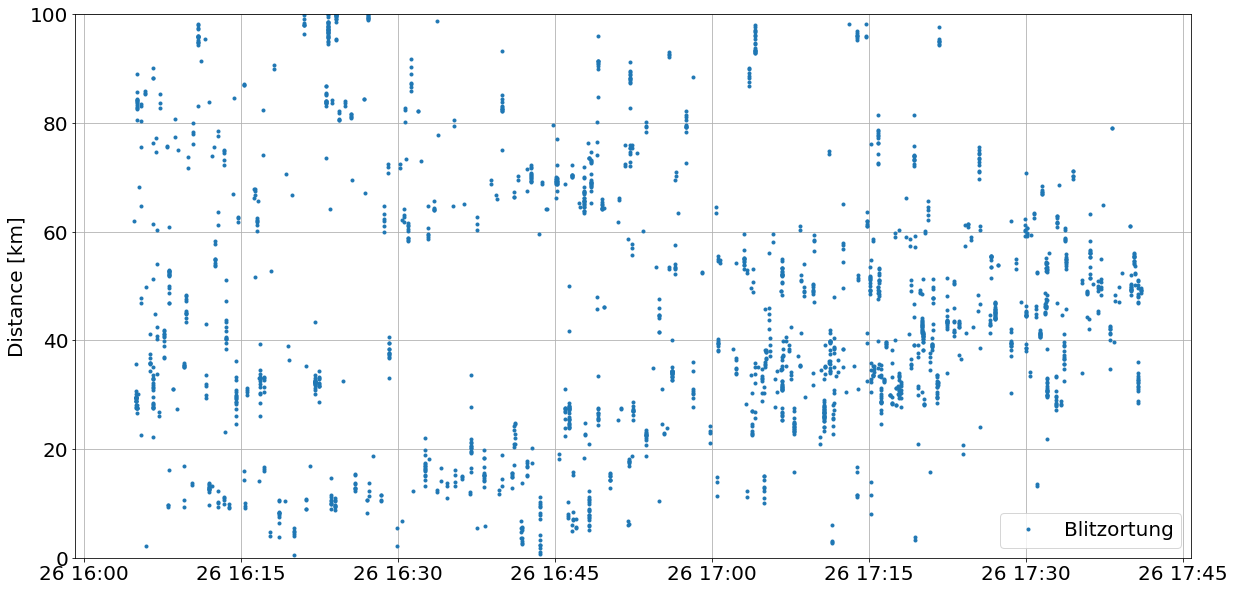

In [126]:
fig, (ax6) = plt.subplots(nrows=1, sharex=True, figsize=(20,10))
plt.rcParams.update({'font.size': 20})

ax6.plot(blitz.time, blitz.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,100)
ax6.grid()
#ax6.vlines(x=gps['timeR'], ymin=0, ymax=130, color='red', label='Trigger STP', lw=1, linestyle='-', alpha=0.3)
ax6.legend()
plt.rcParams.update({'font.size': 20})


In [22]:
import re
import os
import pandas as pd
from readrec import loadrec, assign_time_axis  # Ensure this import is at the top of your file


filepath = '/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF/rec_220826-163022.70'
filepath = '/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF/rec_220826-160903.93'
#filepath = '/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF/rec_220826-161131.74'
         
selected_channels = [0, 1, 3] # Selection of channels with antenna connected


with open(filepath, 'rb') as file:
    fn = os.path.basename(filepath)
    h, samples, synclog = loadrec(file)  # Use actual loadrec function
    t2s, s2t, _, _ = assign_time_axis(fn, h, synclog)  # Use actual assign_time_axis function

    # Use the s2t function to create timestamps for all samples
    timestamps = pd.date_range(start=s2t(0), periods=samples.shape[0], freq=pd.to_timedelta(1/sps, unit='s'))
    combined_data = pd.DataFrame(samples[:, selected_channels], index=timestamps, columns=[f'Channel_{ch}' for ch in selected_channels])


    
 

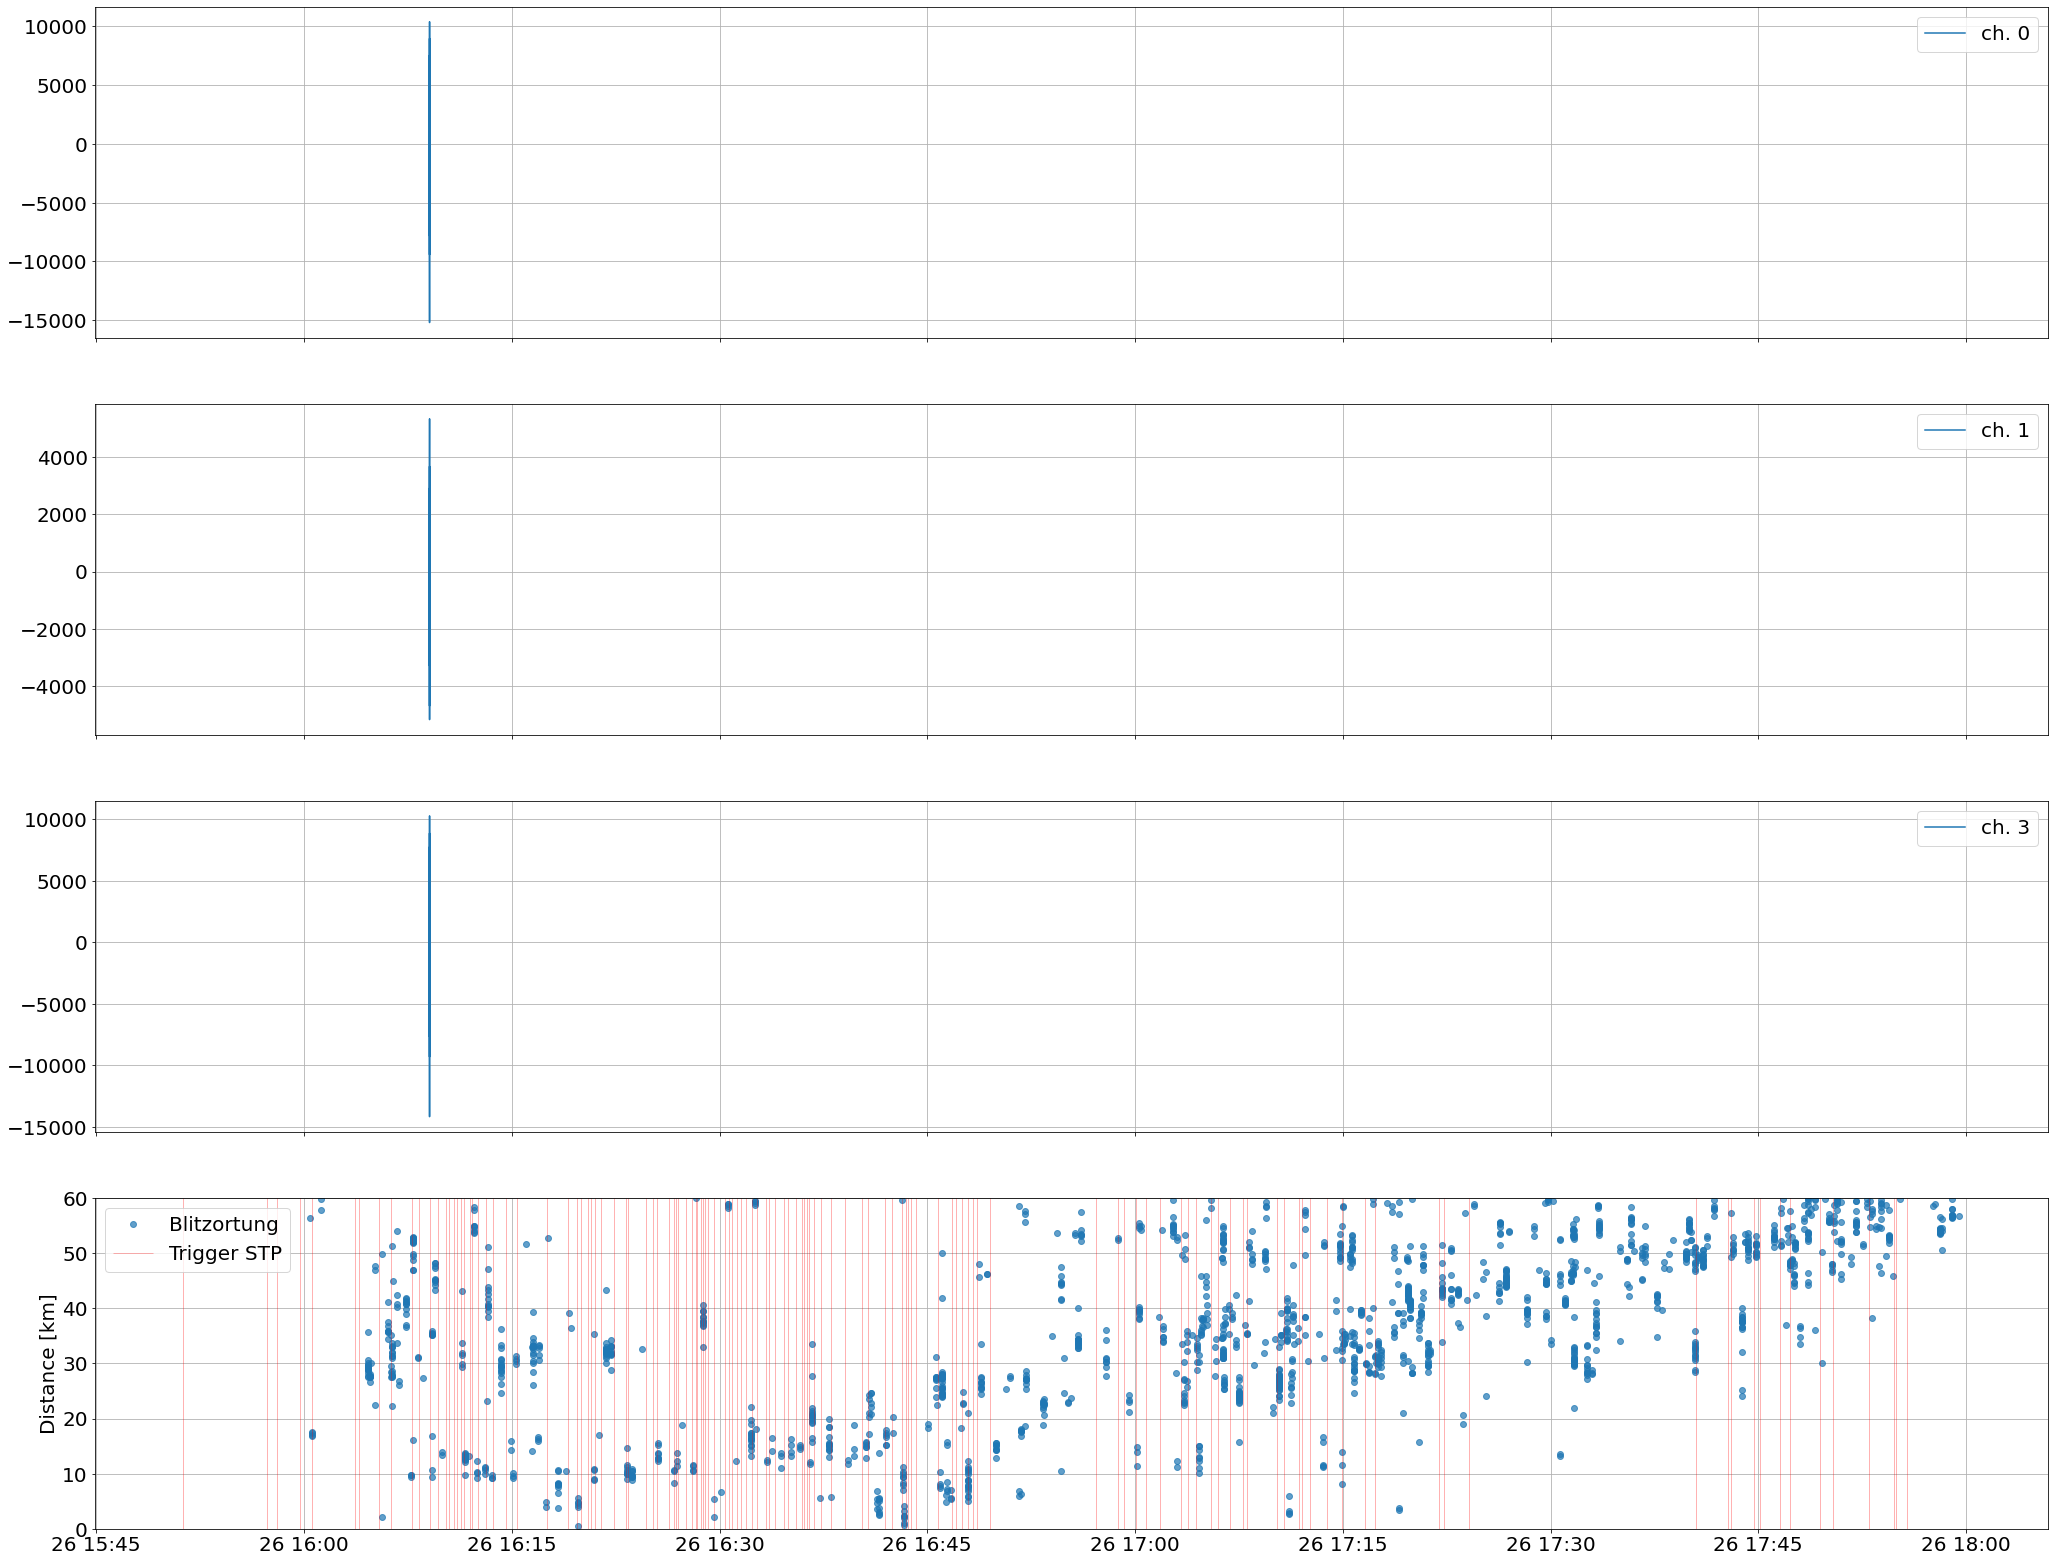

In [29]:


channels = [0, 1, 3]

nrows = 3 + 1
fig, axs = plt.subplots(figsize=(35, 7 * nrows), nrows=nrows, sharex=True)
matplotlib.rcParams.update({'font.size': 20})

mintime = None
data = []

# Render data
ax_idx = 0

for ch in channels:
    axs[ax_idx].plot(combined_data.iloc[:,ax_idx], label='ch. '+str(ch))
    axs[ax_idx].grid()
    axs[ax_idx].legend()
    
    ax_idx += 1

    

axs[ax_idx].plot(blitz.time + pd.to_timedelta(-18, unit='s'), blitz.km, ls='', marker='o', label='Blitzortung', alpha=0.7)
axs[ax_idx].set_ylabel('Distance [km]')
axs[ax_idx].set_ylim(0,60)
axs[ax_idx].grid()
axs[ax_idx].vlines(x=trigger['time'], ymin=0, ymax=60, color='red', label='Trigger STP', lw=1, linestyle='-', alpha=0.3)
axs[ax_idx].legend()

plt.show()


In [87]:
fn = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/triggers.csv'

trigger = pd.read_csv(fn, sep=';', header=None, comment='*', low_memory=False)

trigger['time'] = pd.to_datetime(trigger[1])

trigger = trigger.loc[trigger['time']>start].loc[trigger['time']<end]


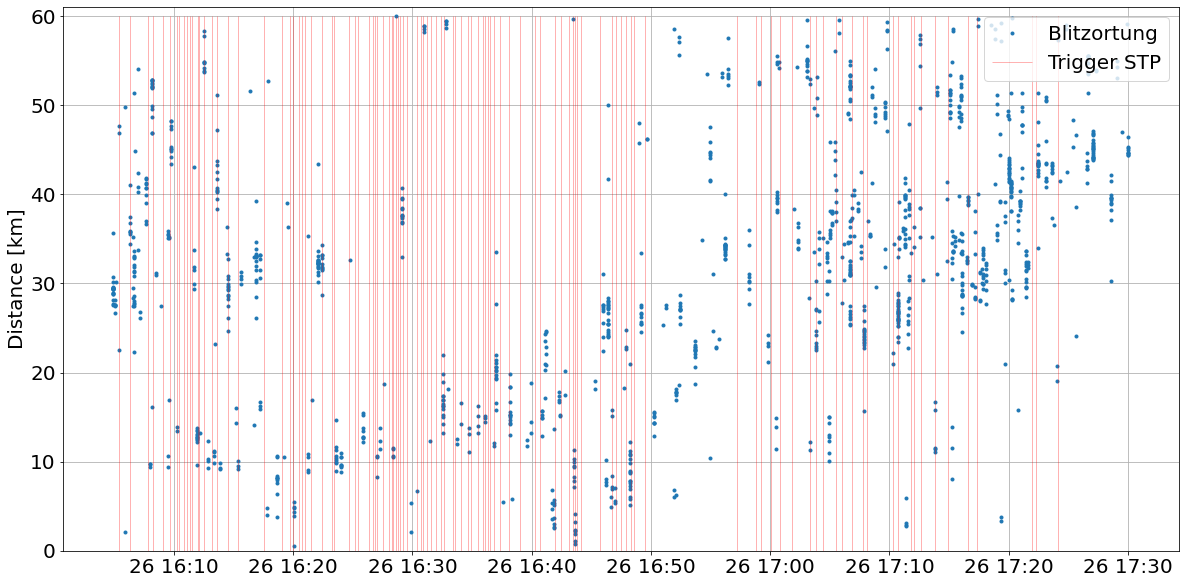

In [39]:
fig, (ax6) = plt.subplots(nrows=1, sharex=True, figsize=(20,10))
plt.rcParams.update({'font.size': 20})

ax6.plot(blitz.time, blitz.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,61)
ax6.grid()
ax6.vlines(x=trigger['time'], ymin=0, ymax=60, color='red', label='Trigger STP', lw=1, linestyle='-', alpha=0.3)
ax6.legend(loc=1)
plt.rcParams.update({'font.size': 20})


In [215]:
directory = '/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF'

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

records2=pd.DataFrame()

sn = '0'
files = sorted(glob.iglob(directory + '/*.??'), key=numericalSort)
for file in files:
    filetime = file.split('/')[-1].split('_')[-1]
    #print(filetime)
    #print(pd.to_datetime(filetime))
    #record['time'] = pd.to_datetime(filetime)
    record = pd.DataFrame({'time':[pd.to_datetime(filetime,format='%y%m%d-%H%M%S.%f')]})
    records2 = pd.concat([records2,record], ignore_index=True)

records2 = records2.loc[records2['time']>start].loc[records2['time']<end]

print('All files was readed.')

All files was readed.


In [219]:
directory = '/storage/experiments/2022/0826_bourka_staryvestec_CAR1/parallella'

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

records1=pd.DataFrame()

sn = '0'
files = sorted(glob.iglob(directory + '/*.??'), key=numericalSort)
for file in files:
    filetime = file.split('/')[-1].split('_')[-1]
    #print(filetime)
    #print(pd.to_datetime(filetime))
    #record['time'] = pd.to_datetime(filetime)
    record = pd.DataFrame({'time':[pd.to_datetime(filetime,format='%y%m%d-%H%M%S.%f')]})
    records1 = pd.concat([records1,record], ignore_index=True)

records1 = records1.loc[records1['time']>start].loc[records1['time']<end]

print('All files was readed.')

All files was readed.


In [217]:
directory = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/parallella-VLF'

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

records0=pd.DataFrame()

sn = '0'
files = sorted(glob.iglob(directory + '/*.??'), key=numericalSort)
for file in files:
    filetime = file.split('/')[-1].split('_')[-1]
    #print(filetime)
    #print(pd.to_datetime(filetime))
    #record['time'] = pd.to_datetime(filetime)
    record = pd.DataFrame({'time':[pd.to_datetime(filetime,format='%y%m%d-%H%M%S.%f')]})
    records0 = pd.concat([records0,record], ignore_index=True)

records0 = records0.loc[records0['time']>start].loc[records0['time']<end]

print('All files was readed.')

All files was readed.


In [161]:
directory = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/chronos'

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

videos0=pd.DataFrame()

sn = '0'
files = sorted(glob.iglob(directory + '/*.mp4'), key=numericalSort)
for file in files:
    filetime = file.split('/')[-1].split('-l')[-2]
    #print(filetime)
    #print(pd.to_datetime(filetime))
    #record['time'] = pd.to_datetime(filetime)
    video = pd.DataFrame({'time':[pd.to_datetime(filetime ,format='%Y-%m-%d-%H-%M-%S.%f')]})
    videos0 = pd.concat([videos0,video], ignore_index=True)

videos0 = videos0.loc[videos0['time']>start].loc[videos0['time']<end]

print('All files was readed.')

All files was readed.


In [162]:
directory = '/storage/experiments/2022/0826_bourka_staryvestec_CAR1/chronos'

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

videos1=pd.DataFrame()

sn = '0'
files = sorted(glob.iglob(directory + '/*-lightning.mp4'), key=numericalSort)
for file in files:
    #print(file)
    filetime = file.split('/')[-1].split('-l')[-2]
    #print(filetime)
    #print(pd.to_datetime(filetime))
    #record['time'] = pd.to_datetime(filetime)
    video = pd.DataFrame({'time':[pd.to_datetime(filetime ,format='%Y-%m-%d-%H-%M-%S.%f')]})
    videos1 = pd.concat([videos1,video], ignore_index=True)

videos1 = videos1.loc[videos1['time']>start].loc[videos1['time']<end]

print('All files was readed.')

All files was readed.


In [152]:
filetime

'2022-08-26-17-57-38.697934'

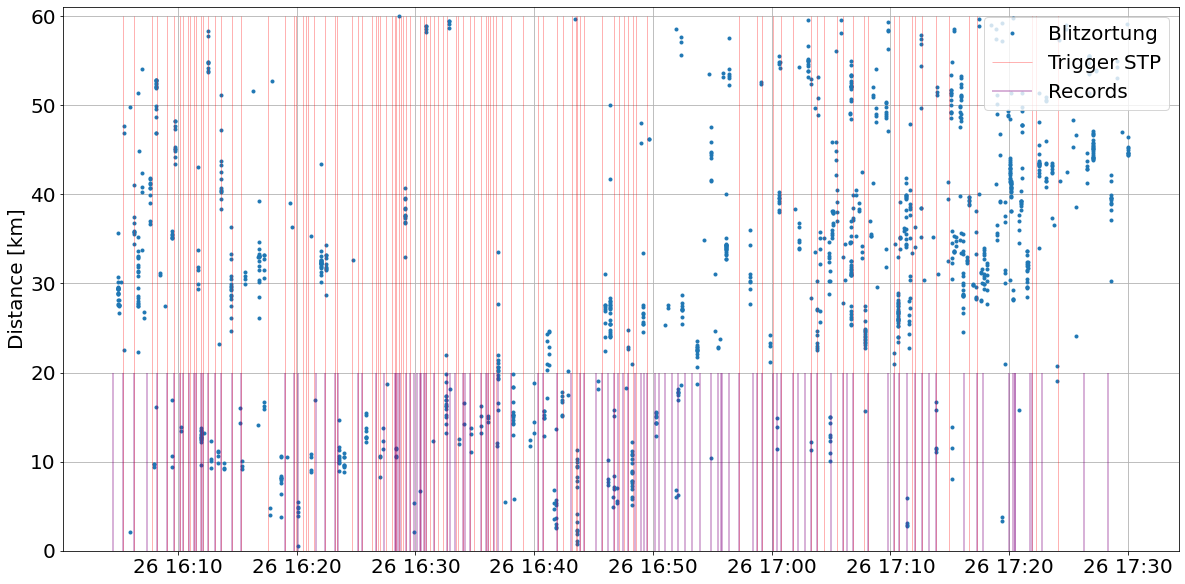

In [98]:
fig, (ax6) = plt.subplots(nrows=1, sharex=True, figsize=(20,10))
plt.rcParams.update({'font.size': 20})

ax6.plot(blitz.time, blitz.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,61)
ax6.grid()
ax6.vlines(x=trigger['time'], ymin=0, ymax=60, color='red', label='Trigger STP', lw=1, linestyle='-', alpha=0.3)
ax6.vlines(x=records['time'], ymin=0, ymax=20, color='purple', label='Records', lw=2, linestyle='-', alpha=0.3)
ax6.legend(loc=1)
plt.rcParams.update({'font.size': 20})


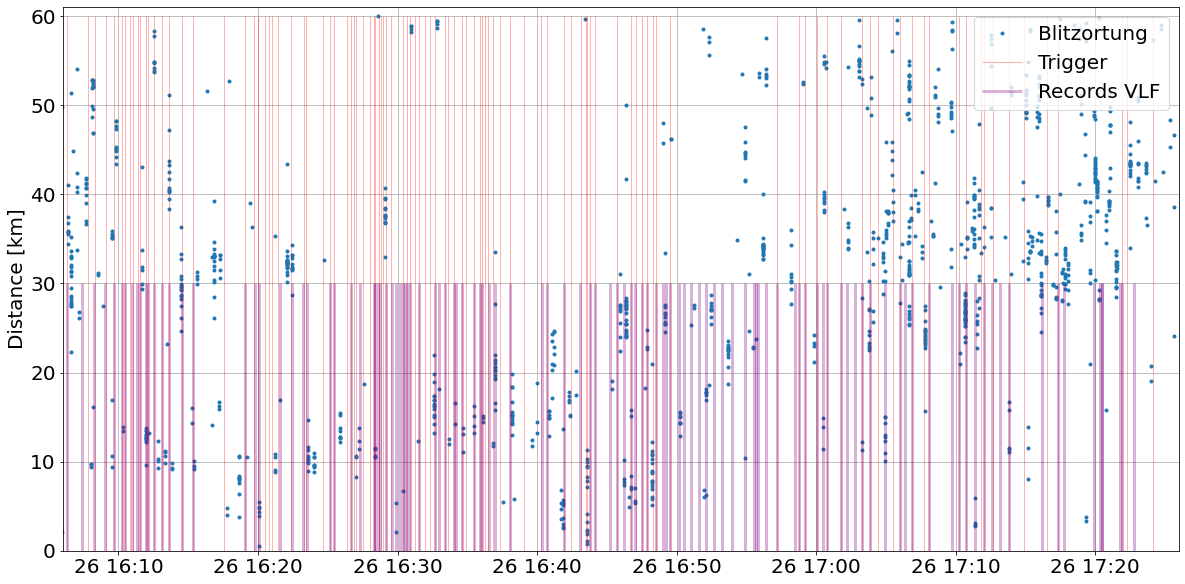

In [108]:
fig, (ax6) = plt.subplots(nrows=1, sharex=True, figsize=(20,10))
plt.rcParams.update({'font.size': 20})

ax6.plot(blitz.time, blitz.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,61)
ax6.grid()
ax6.vlines(x=trigger['time'], ymin=0, ymax=60, color='red', label='Trigger', lw=1, linestyle='-', alpha=0.3)
ax6.vlines(x=records['time'], ymin=0, ymax=30, color='purple', label='Records VLF', lw=3, linestyle='-', alpha=0.3)
ax6.legend(loc=1)
ax6.set_xlim(pd.Timestamp('2022-08-26 16:06:00'),pd.Timestamp('2022-08-26 17:26:00'))
plt.rcParams.update({'font.size': 20})


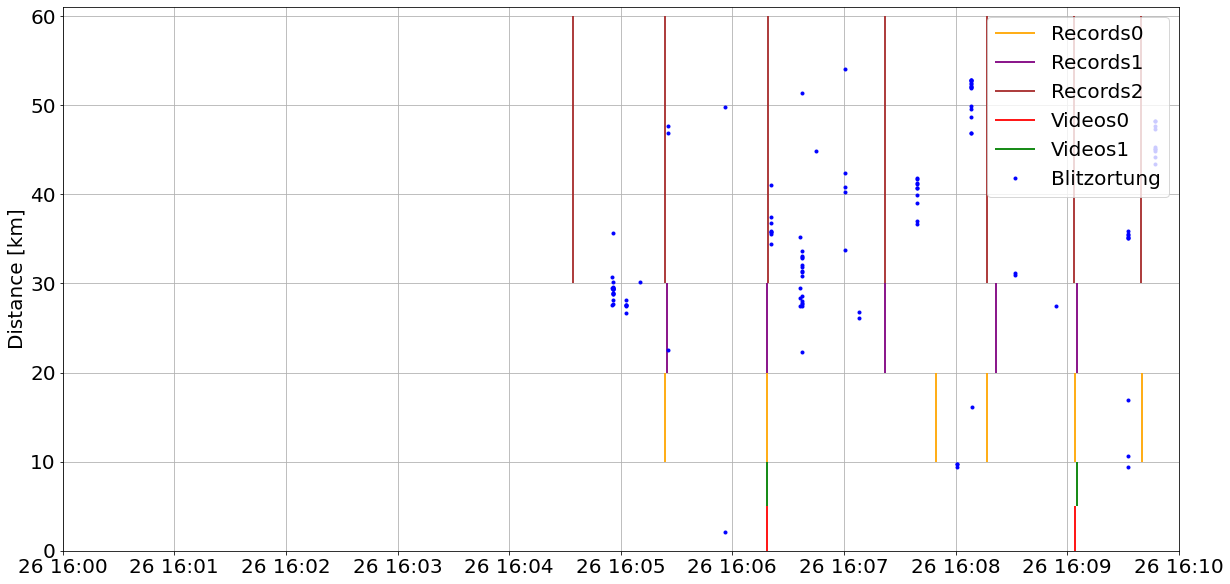

In [242]:
fig, (ax6) = plt.subplots(nrows=1, sharex=True, figsize=(20,10))
plt.rcParams.update({'font.size': 20})

#ax6.vlines(x=trigger['time'], ymin=0, ymax=60, color='red', label='Trigger', lw=1, linestyle='-', alpha=0.5)
ax6.vlines(x=records0['time'], ymin=10, ymax=20, color='orange', label='Records0', lw=2, linestyle='-', alpha=0.9)
ax6.vlines(x=records1['time'], ymin=20, ymax=30, color='purple', label='Records1', lw=2, linestyle='-', alpha=0.9)
ax6.vlines(x=records2['time'], ymin=30, ymax=60, color='brown', label='Records2', lw=2, linestyle='-', alpha=0.9)
ax6.vlines(x=videos0['time'], ymin=0, ymax=5, color='red', label='Videos0', lw=2, linestyle='-', alpha=0.9)
ax6.vlines(x=videos1['time'], ymin=5, ymax=10, color='green', label='Videos1', lw=2, linestyle='-', alpha=0.9)
ax6.plot(blitz.time + pd.to_timedelta(-0, unit='s'), blitz.km, ls='', marker='.', color='blue', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,61)
ax6.grid()
ax6.legend(loc=1)
#ax6.set_xlim(pd.Timestamp('2022-08-26 16:10:00'),pd.Timestamp('2022-08-26 17:30:00'))
ax6.set_xlim(pd.Timestamp('2022-08-26 16:00:00'),pd.Timestamp('2022-08-26 16:10:00'))
plt.rcParams.update({'font.size': 20})


In [127]:
fn = '/storage/experiments/2022/0826_bourka_staryvestec_CAR0/triggers.csv'

trigger0 = pd.read_csv(fn, sep=';', header=None, comment='*', low_memory=False)

trigger0['time'] = pd.to_datetime(trigger0[1])

trigger0 = trigger0.loc[trigger0['time']>start].loc[trigger0['time']<end]


In [128]:
fn = '/storage/experiments/2022/0826_bourka_staryvestec_CAR1/triggers.csv'

trigger1 = pd.read_csv(fn, sep=';', header=None, comment='*', low_memory=False)

trigger1['time'] = pd.to_datetime(trigger1[1])

trigger1 = trigger1.loc[trigger1['time']>start].loc[trigger1['time']<end]


In [129]:
fn = '/storage/experiments/2022/0826_bourka_staryvestec_CAR2/triggers.csv'

trigger2 = pd.read_csv(fn, sep=';', header=None, comment='*', low_memory=False)

trigger2['time'] = pd.to_datetime(trigger2[1])

trigger2 = trigger2.loc[trigger2['time']>start].loc[trigger2['time']<end]


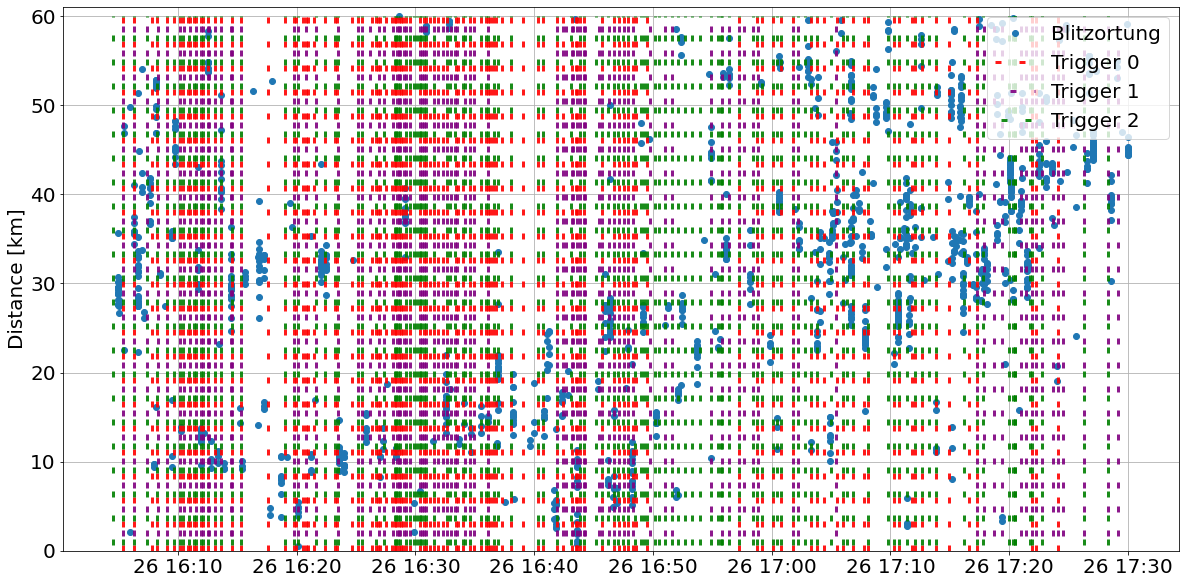

In [83]:
fig, (ax6) = plt.subplots(nrows=1, sharex=True, figsize=(20,10))
plt.rcParams.update({'font.size': 20})

ax6.plot(blitz.time, blitz.km, ls='', marker='o', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,61)
ax6.grid()
ax6.vlines(x=trigger0['time'], ymin=0, ymax=60, color='red', label='Trigger 0', lw=3, linestyle=(0,(2,6)), alpha=0.9)
ax6.vlines(x=trigger1['time'], ymin=0, ymax=60, color='purple', label='Trigger 1', lw=3, linestyle=(3,(2,6)), alpha=0.9)
ax6.vlines(x=trigger2['time'], ymin=0, ymax=60, color='green', label='Trigger 2', lw=3, linestyle=(6,(2,6)), alpha=0.9)
ax6.legend(loc=1)
plt.rcParams.update({'font.size': 20})

#ax6.set_xlim(pd.Timestamp('2022-08-26 17:26:00'),pd.Timestamp('2022-08-26 17:28:00'))

import matplotlib.dates as mdates
#ax6.xaxis.set_minor_locator(mdates.SecondLocator())
#ax6.tick_params(axis='x', which='minor')


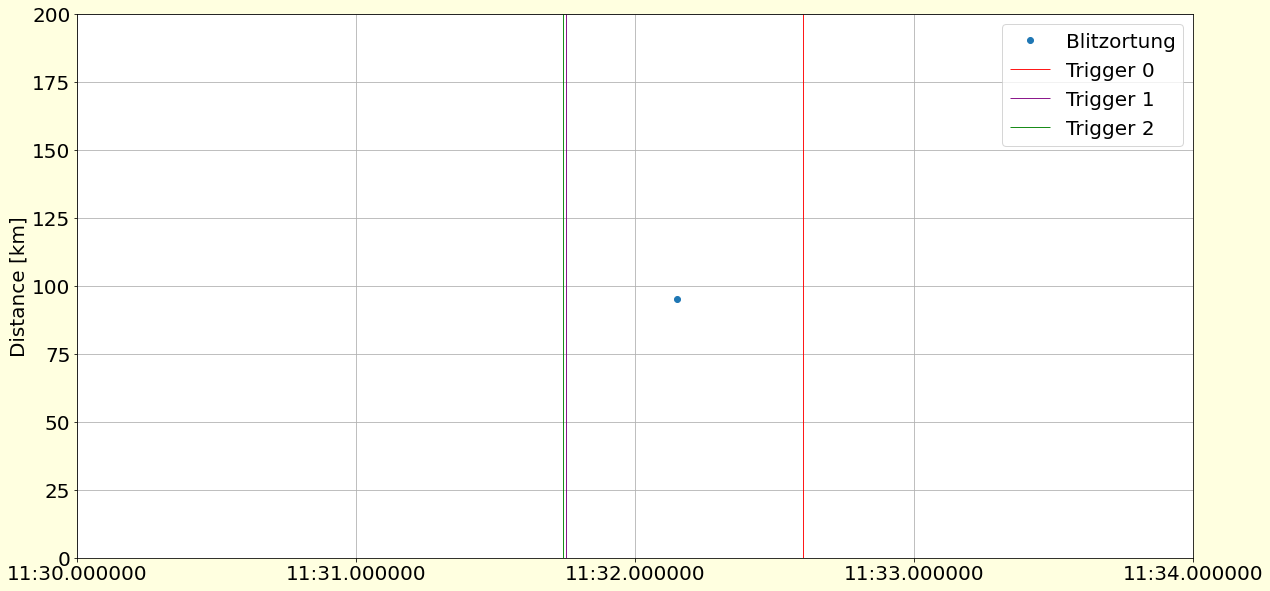

In [193]:
fig, (ax6) = plt.subplots(nrows=1, sharex=True, figsize=(20,10), facecolor='lightyellow')
plt.rcParams.update({'font.size': 20})

ax6.plot(blitz.time + pd.to_timedelta(-0, unit='s'), blitz.km, ls='', marker='o', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,200)
ax6.grid()
ax6.vlines(x=trigger0['time'], ymin=0, ymax=200, color='red', label='Trigger 0', lw=1, linestyle='-', alpha=0.9)
ax6.vlines(x=trigger1['time'], ymin=0, ymax=200, color='purple', label='Trigger 1', lw=1, linestyle='-', alpha=0.9)
ax6.vlines(x=trigger2['time'], ymin=0, ymax=200, color='green', label='Trigger 2', lw=1, linestyle='-', alpha=0.9)
ax6.legend(loc=1)
plt.rcParams.update({'font.size': 20})

ax6.set_xlim(pd.Timestamp('2022-08-26 16:06:00'),pd.Timestamp('2022-08-26 17:00:00')) # 
ax6.set_xlim(pd.Timestamp('2022-08-26 16:06:15'),pd.Timestamp('2022-08-26 16:06:25')) # 1. blesk 0, -18
#ax6.set_xlim(pd.Timestamp('2022-08-26 16:09:00'),pd.Timestamp('2022-08-26 16:09:10')) # 2. blesk mic
ax6.set_xlim(pd.Timestamp('2022-08-26 16:11:30'),pd.Timestamp('2022-08-26 16:11:34')) # 3. blesk 0 
#ax6.set_xlim(pd.Timestamp('2022-08-26 16:23:29'),pd.Timestamp('2022-08-26 16:23:32')) # 4. blesk -36
#ax6.set_xlim(pd.Timestamp('2022-08-26 17:12:38'),pd.Timestamp('2022-08-26 17:12:40')) # 5. blesk +36
#ax6.set_xlim(pd.Timestamp('2022-08-26 17:14:54'),pd.Timestamp('2022-08-26 17:14:58')) # 6. blesk -18, 
#ax6.set_xlim(pd.Timestamp('2022-08-26 17:26:14'),pd.Timestamp('2022-08-26 17:26:17')) # 7. blesk -18, +36
#ax6.set_xlim(pd.Timestamp('2022-08-26 17:40:00'),pd.Timestamp('2022-08-26 17:41:00')) # 8. blesk +36

import matplotlib.dates as mdates
#ax6.xaxis.set_minor_locator(mdates.SecondLocator())
#ax6.tick_params(axis='x', which='minor')


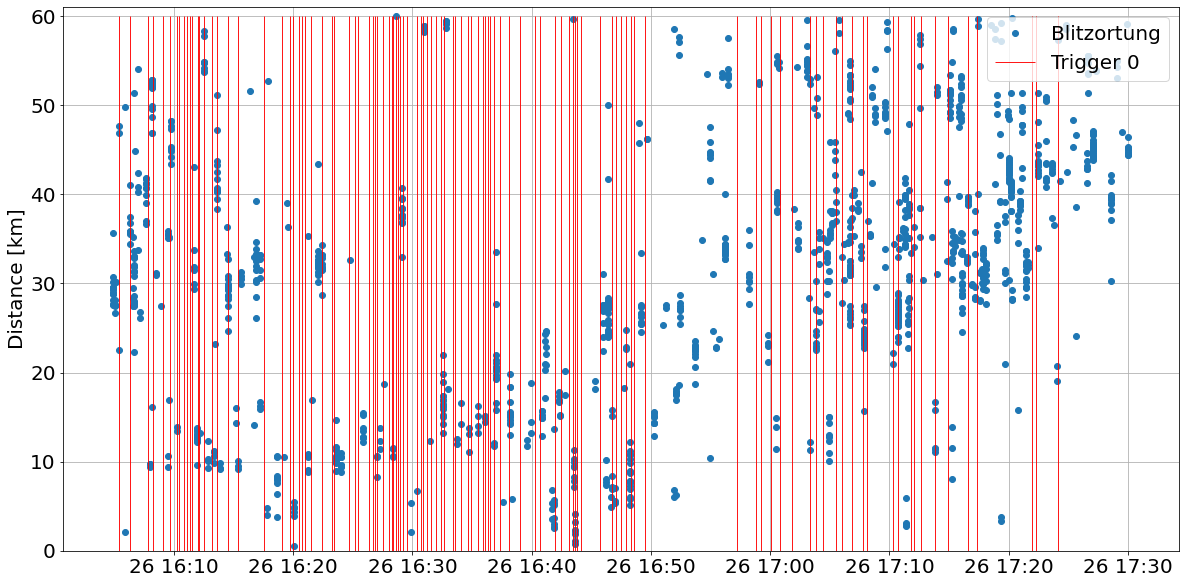

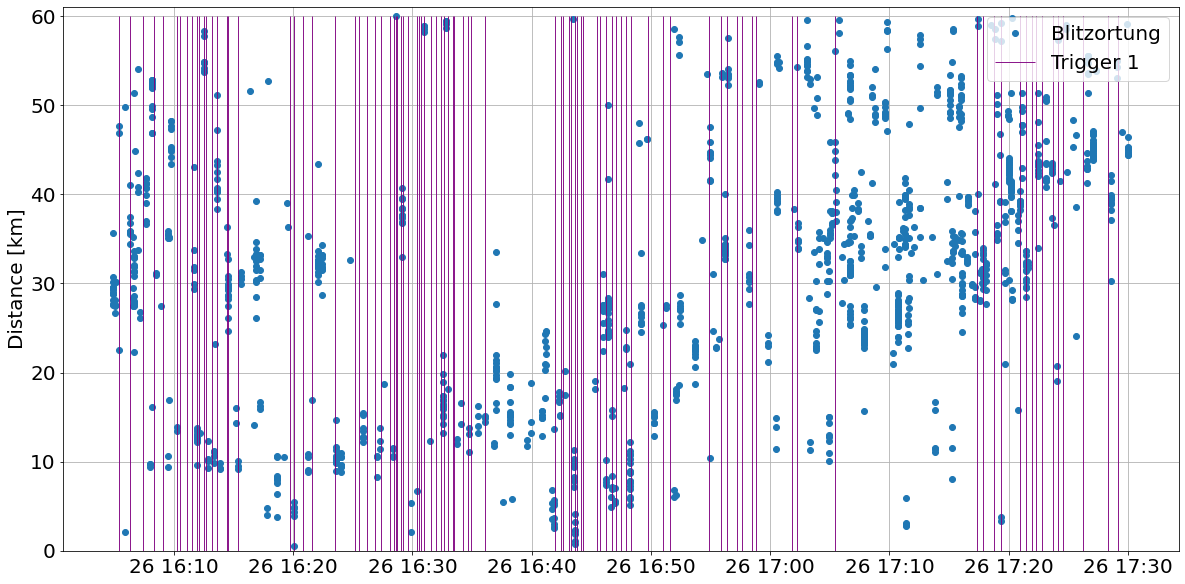

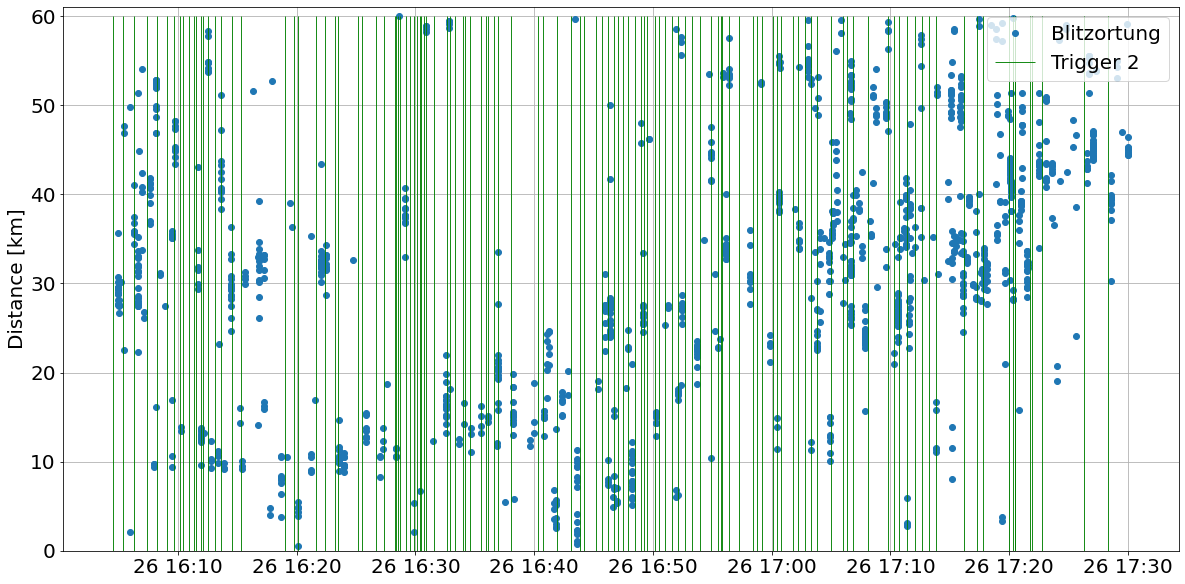

In [84]:
fig, (ax6) = plt.subplots(nrows=1, sharex=True, figsize=(20,10))
plt.rcParams.update({'font.size': 20})
ax6.plot(blitz.time, blitz.km, ls='', marker='o', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,61)
ax6.grid()
ax6.vlines(x=trigger0['time'], ymin=0, ymax=60, color='red', label='Trigger 0', lw=1, linestyle='-', alpha=0.9)
ax6.legend(loc=1)

fig, (ax6) = plt.subplots(nrows=1, sharex=True, figsize=(20,10))
plt.rcParams.update({'font.size': 20})
ax6.plot(blitz.time, blitz.km, ls='', marker='o', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,61)
ax6.grid()
ax6.vlines(x=trigger1['time'], ymin=0, ymax=60, color='purple', label='Trigger 1', lw=1, linestyle='-', alpha=0.9)
ax6.legend(loc=1)

fig, (ax6) = plt.subplots(nrows=1, sharex=True, figsize=(20,10))
plt.rcParams.update({'font.size': 20})
ax6.plot(blitz.time, blitz.km, ls='', marker='o', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,61)
ax6.grid()
ax6.vlines(x=trigger2['time'], ymin=0, ymax=60, color='green', label='Trigger 2', lw=1, linestyle='-', alpha=0.9)
ax6.legend(loc=1)
